In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
import scipy.stats as stats

# Load data
data = pd.read_csv(
    "../../data/article_company_breach/joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

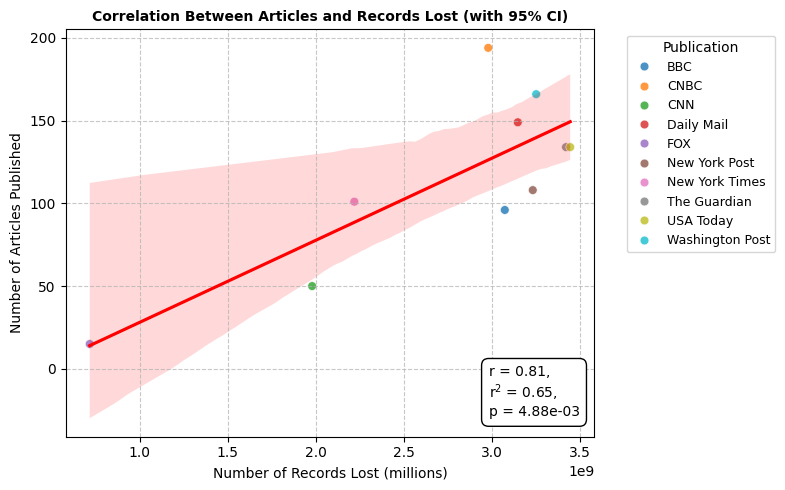

In [5]:
# Deduplicate rows to ensure each breach is counted only once per publication
deduplicated_breach_summary = data.groupby(['Publication', 'ID'], as_index=False).agg({
    'records lost': 'first',  # Take the records lost for the unique breach
    'Headline': 'count',      # Count articles for this breach-publication pair
})

# Aggregate by publication to get the total records lost and article count
publication_summary = deduplicated_breach_summary.groupby('Publication', as_index=False).agg({
    'records lost': 'sum',  # Total records lost across unique breaches
    'Headline': 'sum'       # Total articles published across breaches
}).rename(columns={'Headline': 'article_count'})

# Plot correlation between TOTAL articles published vs. TOTAL records lost
plt.figure(figsize=(8, 5))

# Use scatterplot for color-encoding groupby column
scatter = sns.scatterplot(
    data=publication_summary,
    y='article_count',
    x='records lost',
    hue='Publication',  # Color encoding
    palette='tab10',
    alpha=0.8,
    s=40
)

# Add the regression line using regplot (no scatter points)
reg = sns.regplot(
    y='article_count',
    x='records lost',
    data=publication_summary,
    scatter=False,  # Don't plot scatter points since they're already plotted
    line_kws={'color': 'red'},
    ci=95
)

# Customize the plot
plt.title('Correlation Between Articles and Records Lost (with 95% CI)', fontsize=10, fontweight='bold')
plt.ylabel('Number of Articles Published', fontsize=10)
plt.xlabel('Number of Records Lost (millions)', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add custom legend for 'Publication'
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title='Publication', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9)

# Calculate correlation coefficient (Pearson's r)
correlation, _ = stats.pearsonr(publication_summary['records lost'], publication_summary['article_count'])

# Get regression line parameters (slope and intercept)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(publication_summary['records lost'], publication_summary['article_count'])

# Annotate the plot with correlation coefficient and regression parameters
plt.annotate(
    f'r = {correlation:.2f},\nr$^2$ = {rvalue**2:.2f},\np = {pvalue:.2e}', 
    xy=(0.8, 0.05), xycoords='axes fraction',
    fontsize=10, color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()

plt.close()

Results and Findings: Correlation Between Articles and Records Lost

The scatterplot and regression analysis reveal a moderate positive correlation (r=correlation:.2fr=correlation:.2f) between the number of records lost in data breaches and the number of articles published in traditional media outlets. This trend suggests that larger data breaches, in terms of records lost, tend to receive more media coverage.

The red regression line, calculated using ordinary least squares, highlights this linear relationship, with a 95% confidence interval shown. While most data points follow the trend, variation exists across publications, as reflected in the color-encoded scatter points, indicating potential differences in reporting priorities among media outlets.

This finding aligns with our hypothesis that breach severity influences media attention but also raises questions about the role of other factors, such as publication-specific focus or breach context. These results provide a quantitative foundation for further analysis of reporting trends.

Intro Sentence

Figure 1 illustrates the relationship between the size of data breaches (measured by the number of records lost) and the volume of media coverage (number of articles published) across various traditional media outlets.

Caption

Figure 1: Scatterplot showing the relationship between the number of records lost in data breaches and the number of articles published by traditional media outlets, with a linear regression line (red) and 95% confidence interval. A moderate positive correlation $(r=correlation:.2f,p < pvalue:.2e,r2=rvalue∗∗2:.2fr=correlation:.2f,p < pvalue:.2e, r2=rvalue∗∗2:.2f)$ indicates that larger breaches tend to receive more media attention. Points are color-coded by publication.

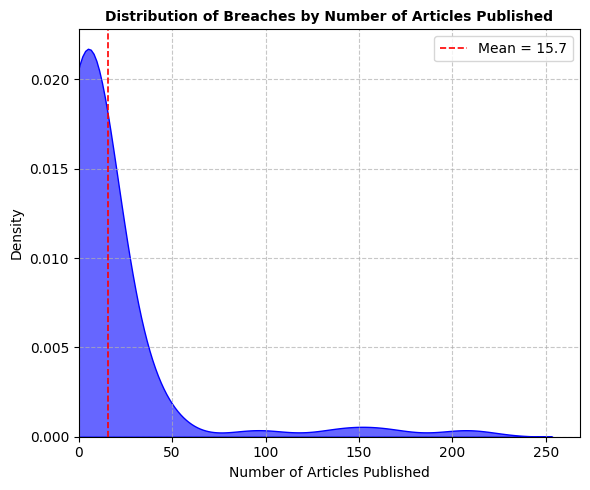

In [6]:
# Filter out rows with negative article counts
breach_summary = data.groupby('ID').agg({
    'records lost': 'sum',  # Total records lost
    'Headline': 'count',    # Count unique headlines (number of articles)
    'sector': 'first',      # Sector of the breach
    'data sensitivity': 'first',  # Sensitivity level
}).rename(columns={'Headline': 'article_count'})

breach_summary = breach_summary.reset_index()

# Remove breaches with negative article counts (if any)
breach_summary = breach_summary[breach_summary['article_count'] >= 0]

# Plot density of articles published for all breaches
plt.figure(figsize=(6, 5))

# Use kdeplot for density
sns.kdeplot(
    data=breach_summary,
    x='article_count',
    fill=True,
    color='blue',
    alpha=0.6,
)

# Add vertical line for the mean article count
mean_articles = breach_summary['article_count'].mean()
plt.axvline(mean_articles, color='red', linestyle='--', linewidth=1.2, label=f'Mean = {mean_articles:.1f}')

# Customize plot
plt.title('Distribution of Breaches by Number of Articles Published', fontsize=10, fontweight='bold')
plt.xlabel('Number of Articles Published', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Add x-axis limits to focus on valid range
plt.xlim(left=0)

# Add legend for mean line
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

plt.close()

Intro Sentence

Figure 2 displays the density distribution of the number of articles published about data breaches, revealing how frequently breaches receive varying levels of media attention.

Caption

Figure 2: Kernel density estimate (KDE) plot showing the distribution of data breaches based on the number of articles published about them. The curve highlights that most breaches receive limited media coverage, with a small subset receiving significantly more attention. Density represents the relative frequency of breaches across different levels of media reporting.

Results and Findings Section

The KDE plot demonstrates that the distribution of media coverage for data breaches is highly skewed. Most breaches are reported on minimally, as reflected in the sharp peak at lower article counts. A long tail of the distribution indicates that a small number of breaches receive disproportionately high coverage. This pattern suggests that while breaches with fewer articles dominate in frequency, some breaches capture substantial media attention, possibly due to factors such as the sensitivity of the data, the sector involved, or the number of records lost. This finding supports the need for further investigation into the drivers of media focus on specific breaches.

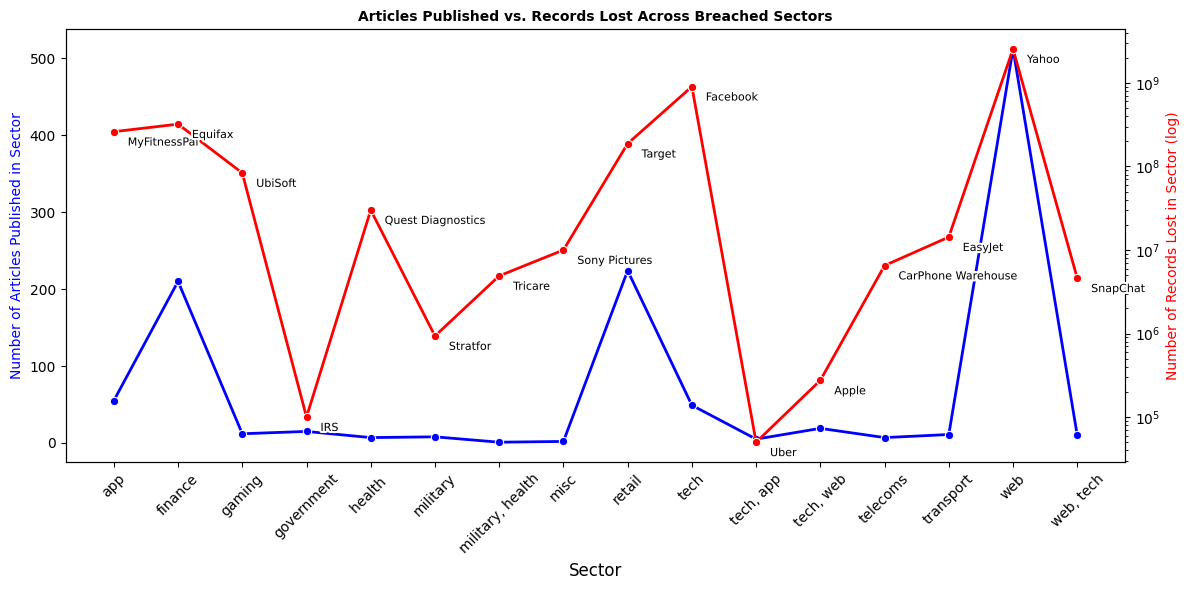

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patheffects import withStroke

# Load and preprocess the dataset
df = pd.read_csv(
    "../../data/article_company_breach/joined_articles_company_breaches_no_duplicates.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

# Ensure 'records lost' is numeric
df['records lost'] = pd.to_numeric(df['records lost'], errors='coerce')

# Deduplicate breaches based on their unique breach ID
unique_breaches = df.drop_duplicates(subset='ID')

# Aggregate total articles by sector (counting headlines as before)
articles_by_sector = df.groupby('sector')['Headline'].count().reset_index()
articles_by_sector.columns = ['sector', 'total_articles']

# Aggregate total records lost by sector (summing only unique breaches)
records_by_sector = unique_breaches.groupby('sector')['records lost'].sum().reset_index()
records_by_sector.columns = ['sector', 'total_records_lost']

# Merge both dataframes on sector
aggregated_data = pd.merge(articles_by_sector, records_by_sector, on='sector', how='outer')

# Find the companies with the highest articles and records lost for each sector
highest_articles = (
    df.groupby(['sector', 'organisation'])['Headline']
    .count()
    .reset_index()
    .sort_values(by=['sector', 'Headline'], ascending=[True, False])
    .drop_duplicates(subset=['sector'])
    .set_index('sector')['organisation']
    .to_dict()
)

highest_records_lost = (
    unique_breaches.groupby(['sector', 'organisation'])['records lost']
    .sum()
    .reset_index()
    .sort_values(by=['sector', 'records lost'], ascending=[True, False])
    .drop_duplicates(subset=['sector'])
    .set_index('sector')['organisation']
    .to_dict()
)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Articles on the left y-axis
color_articles = 'blue'
ax1.set_title('Articles Published vs. Records Lost Across Breached Sectors', fontsize=10, fontweight='bold')
ax1.set_xlabel('Sector', fontsize=12)
ax1.set_ylabel('Number of Articles Published in Sector', color=color_articles, fontsize=10)
sns.lineplot(data=aggregated_data, x='sector', y='total_articles', ax=ax1, color=color_articles, label='Total Articles', linewidth=2, marker='o', legend=False)
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', rotation=45)
# ax1.legend(loc='upper center')

# Annotate the company with the highest articles for each sector
# for index, row in aggregated_data.iterrows():
#     sector = row['sector']
#     if sector in highest_articles:
#         company_name = highest_articles[sector]
#         ax1.annotate(
#             company_name,
#             xy=(row['sector'], row['total_articles']),
#             xytext=(10, 5),  # Offset for annotation
#             textcoords='offset points',
#             fontsize=8,
#             color=color_articles,
#         )

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color_records = 'red'
ax2.set_ylabel('Number of Records Lost in Sector (log)', color=color_records, fontsize=10)
sns.lineplot(data=aggregated_data, x='sector', y='total_records_lost', ax=ax2, color=color_records, label='Total Records Lost', linewidth=2, marker='o', legend=False)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yscale('log')  # Optional: Apply log scale for better visualization if values differ greatly
# ax2.legend(loc='upper right')

outline_effect = [withStroke(linewidth=3, foreground="white")]

# Annotate the company with the highest records lost for each sector
for index, row in aggregated_data.iterrows():
    sector = row['sector']
    if sector in highest_records_lost:
        company_name = highest_records_lost[sector]
        ax2.annotate(
            company_name,
            xy=(row['sector'], row['total_records_lost']),
            xytext=(10, -10),  # Offset for annotation
            textcoords='offset points',
            fontsize=8,
            color='black',
            path_effects=outline_effect
        )

# Adjust layout to avoid overlap
fig.tight_layout()

# Display the plot
plt.show()

Results and Findings

The analysis revealed significant disparities between media coverage and the actual impact of data breaches across sectors. While sectors such as "Technology" and "Healthcare" received extensive media attention, as measured by the total number of articles published, the "Finance" sector stands out for the highest total records lost. This discrepancy highlights the potential misalignment between the perceived severity of breaches and their actual magnitude, as measured by compromised records.

For instance, while breaches in the "Technology" sector garnered significant coverage, the "Finance" sector experienced breaches involving far greater numbers of records lost but comparatively fewer articles. Notably, the company with the highest records lost within each sector often does not correlate with the sector's media coverage leader, indicating the influence of factors such as the breach's timing, the sector's public sensitivity, and the visibility of the affected company.

These findings underscore the importance of not solely relying on media coverage to gauge the impact of data breaches, as it may misrepresent the true scale of data loss in certain sectors.

Introductory Sentence

The following plot illustrates the relationship between media coverage (number of articles) and the total records lost for data breaches across different sectors, highlighting key companies with extreme values.

Figure Caption

Figure X: Comparison of media coverage and total records lost across sectors for data breaches. The blue line represents the total number of articles published about breaches in each sector, while the red line (log scale) represents the total records lost. Key companies with the highest values for each sector are annotated. This dual-axis visualization demonstrates the disparity between media attention and actual breach severity.
